# AuTextification

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings

# Suppress FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning)

Skip the preprocess (faster)

In [2]:
root = './data/competition_2024/new_preprocessed_data_subtask1/'

train_en_preprocessed = pd.read_csv(root+'train_en_preprocessed.csv')
train_es_preprocessed = pd.read_csv(root+'train_es_preprocessed.csv')
train_ca_preprocessed = pd.read_csv(root+'train_ca_preprocessed.csv')
train_pt_preprocessed = pd.read_csv(root+'train_pt_preprocessed.csv')
train_eu_preprocessed = pd.read_csv(root+'train_eu_preprocessed.csv')
train_gl_preprocessed = pd.read_csv(root+'train_gl_preprocessed.csv')

train_preprocessed = pd.read_csv(root+'train_preprocessed.csv')

# Preprocess

## Data

In [3]:
train = pd.read_csv('C:/Users/34686/3CD - 23_24/PROY III/autextification/data_24/subtask1.csv').drop(columns='Unnamed: 0')
train.head()

,id,text,label
0,15442,Es un tribunal de suprema instanza que forma p...,generated
1,26409,Aixó de tindrer la platgeta tant prou era un p...,human
2,12777,Doug mcadam es un científico estadista estadou...,generated
3,63467,"El president de la generalitat, carles puigdem...",generated
4,41050,"Traídas de francia, tan estrafalarias que una ...",generated


## Identifying languages

* English (en)
* Spanish (es)
* Portuguese (pt)
* Galician (gl)
* Basque (eu)
* Catalan (ca)

https://www.toolify.ai/es/ai-news-es/7-herramientas-nlp-para-deteccin-de-idioma-en-python-1143843

### Identification with different libreries

#### Lang id

In [4]:
#### Lang id
from py3langid.langid import LanguageIdentifier, MODEL_FILE

identifier = LanguageIdentifier.from_pickled_model(MODEL_FILE)
identifier.set_languages(['en', 'es', 'pt', 'gl', 'eu', 'ca'])
identifier.classify(train.loc[0, 'text'])

def language_detector_lingua_langid(text):
    return identifier.classify(text)[0]


#### Lang detect (not worth it)

In [5]:
#### Langdetect
from langdetect import detect  # pip install langdetect
from langdetect import detect_langs

# train['text'][:100].apply(detect)
# train['text'][:100]

#### Fasttext

In [6]:
import fasttext
model_path = 'modules/lan_id/lid.176.bin'  # ruta al modelo pre-entrenado
model = fasttext.load_model(model_path)

def language_detector_fasttext_all(text):
    predicted_languages = model.predict(text)
    language_code = predicted_languages[0][0].replace('__label__', '')
    return language_code


In [7]:
import fasttext

model_path = 'modules/lan_id/lid.176.bin'  # ruta al modelo pre-entrenado
model = fasttext.load_model(model_path)

allowed_languages = ['ca', 'es', 'en', 'eu', 'pt', 'gl']

def language_detector_fasttext(text):
    predicted_languages, probabilities = model.predict(text, k=-1)  
    for language, probability in zip(predicted_languages, probabilities):
        language_code = language.replace('__label__', '')
        if language_code in allowed_languages:
            return language_code
    return None  # if language not in allowed


#### Lingua (doesn't include gl)

In [11]:
#### Lingua
from scipy.sparse import csr_matrix
# from lingua import Language, LanguageDetectorBuilder
from sklearn.metrics import confusion_matrix


def language_detector_lingua(text):
    language = detector.detect_language_of(text)
    if language == Language.CATALAN:
        return 'ca'
    elif language == Language.SPANISH:
        return 'es'
    elif language == Language.BASQUE:
        return 'eu'
    elif language == Language.PORTUGUESE:
        return 'pt'
    elif language == Language.ENGLISH:
        return 'en'


In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def check_with_lingua(df=train, remove=False):
    
    df['lang_detected:langid'] = df['text'].apply(language_detector_lingua_langid)
    df['lang_detected:lingua'] = df['text'].apply(language_detector_lingua)

    languages_detected = sorted(df['lang_detected:langid'].unique())
    languages_check = sorted(df['clang_detected:lingua'].unique())
    languages = sorted(set(languages_detected + languages_check))  # Unir idiomas únicos

    conf_matrix = confusion_matrix(df['lang_detected:lingua'], df['lang_detected:langid'], labels=languages)
    df['pred_correct'] = df['lang_detected:lingua'] == df['lang_detected:langid']


    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=languages, yticklabels=languages)
    plt.xlabel('Langid')
    plt.ylabel('Lingua')
    plt.title('Confusion matrix')
    plt.show()
    
    if remove: # Remove missclassifications

        incorrect = df.loc[df['pred_correct'] == False]
        mix_languages = incorrect.loc[incorrect['detected_language'] != 'gl']
        filas_borrar = mix_languages.index
        df.drop(filas_borrar, axis=0, inplace=False)



### Aplication

In [13]:
## Lang id
train['lang_detected:langid'] = train['text'].apply(language_detector_lingua_langid)


In [14]:
## Fasttext mix of languages
train['lang_detected:all_fasttext'] = train['text'].apply(language_detector_fasttext_all)
train[train["lang_detected:langid"] != train["lang_detected:all_fasttext"]] # 1611 con mezcla de textos

,id,text,label,lang_detected:langid,lang_detected:all_fasttext
135,130237,#bieberfever #justinbieber #belieber #purpose ...,generated,es,en
210,103681,Pó só e pan ralado deu só e água que tá nascen...,generated,gl,pt
315,134694,Acontecementos pilemenes ii sucede a pilemenes...,human,es,gl
372,110951,Morro cabeça no tempo brasilgo udalerri bat da...,human,pt,eu
401,47888,@vilarcapella ja hem tornat: pericos 3 - jupit...,human,ca,sv
...,...,...,...,...,...
109320,127651,"E m""encanta aquesta cançó! sempre que la sento...",generated,pt,ca
109478,68269,Adoro o facto de ñ conseguir tirar mais ningué...,human,gl,pt
109504,149412,"Simplemente, agradecerche que esteas ahí día a...",human,es,gl
109518,11249,@topstockoutlet ¿deseas renovar tu tienda o in...,generated,gl,es


In [15]:
## Fasttext Bad classified
train['lang_detected:fasttext'] = train['text'].apply(language_detector_fasttext)

In [16]:
for i, row in train[train["lang_detected:langid"] != train["lang_detected:fasttext"]].iterrows():
    print(f'Iteration nº {i}')
    print(f'Text: {row.text[:50]}')
    print(f'Langid: {row["lang_detected:langid"]}')
    print(f'Fasttext: {row["lang_detected:fasttext"]}')
    print()


Iteration nº 135
Text: #bieberfever #justinbieber #belieber #purpose #lov
Langid: es
Fasttext: en

Iteration nº 210
Text: Pó só e pan ralado deu só e água que tá nascendo q
Langid: gl
Fasttext: pt

Iteration nº 315
Text: Acontecementos pilemenes ii sucede a pilemenes i n
Langid: es
Fasttext: gl

Iteration nº 372
Text: Morro cabeça no tempo brasilgo udalerri bat da, pi
Langid: pt
Fasttext: eu

Iteration nº 552
Text: ¡wow! ¡qué manera de exagerar! cristiano ronaldo n
Langid: pt
Fasttext: es

Iteration nº 582
Text: Galician news article: italianos desanimados tras 
Langid: gl
Fasttext: es

Iteration nº 605
Text: Puigdemont reprend une paroles de rajoy pour défen
Langid: en
Fasttext: ca

Iteration nº 799
Text: ¡oh, señor!, ¡oh, rey!, ¡oh, amo!, ¡oh, amado!, ¡o
Langid: gl
Fasttext: es

Iteration nº 993
Text: Fons salutaris, llibertat, lluny, és la meva alma 
Langid: en
Fasttext: ca

Iteration nº 1207
Text: @vivi_l_crawford @victoriajustice @dylanobrien dif
Langid: es
Fasttext: pt

Iteration

Langid: pt
Fasttext: gl

Iteration nº 29621
Text: A empresa smartpeme, unha rede de xeitos tecnolóxi
Langid: gl
Fasttext: es

Iteration nº 29743
Text: Xa que o meu amor non se chega a chegar, xa que o 
Langid: gl
Fasttext: pt

Iteration nº 29829
Text: Follas novas, follas de outono, a un batido, outro
Langid: gl
Fasttext: pt

Iteration nº 29929
Text: Retrònan, y a"n es morts els-a despertan mentras t
Langid: es
Fasttext: ca

Iteration nº 29958
Text: Produto bom produto bom produto bom produto bom pr
Langid: en
Fasttext: pt

Iteration nº 30146
Text: @magdalenaproust @xosedaflor lugo é un tema musica
Langid: es
Fasttext: pt

Iteration nº 30417
Text: @injinji los carnavales como se os entrega un fazo
Langid: es
Fasttext: gl

Iteration nº 30448
Text: Basque (euskara): bilboko suhiltzaileek australiar
Langid: en
Fasttext: eu

Iteration nº 30502
Text: Nas mentes senpre ter devemo-las sas feituras da v
Langid: gl
Fasttext: pt

Iteration nº 30630
Text: Placebo al festival de cap roig, 1 d" ago


Iteration nº 58403
Text: Unha nova vida comeza hoxe! descubrindo novos reto
Langid: pt
Fasttext: gl

Iteration nº 58422
Text: "@jepeto13: seguint la #duatlóstjoanab !! esperem 
Langid: ca
Fasttext: es

Iteration nº 58648
Text: ¡comparte! se non te valoras ti mesmo nadie te vai
Langid: es
Fasttext: pt

Iteration nº 58712
Text: Werk ohne autor é un filme alemán de 2018 escrito 
Langid: es
Fasttext: gl

Iteration nº 58785
Text: @axeladrianlopez bua es muy ssobrau a mmi no me gg
Langid: pt
Fasttext: es

Iteration nº 58813
Text: Inspira el teu treball de recerca coworking lloret
Langid: ca
Fasttext: es

Iteration nº 58942
Text: Com el raig al vent nega envolup primer, com l"her
Langid: ca
Fasttext: es

Iteration nº 58946
Text: E o luns, tivemos a celebración e escoitamos a mar
Langid: es
Fasttext: gl

Iteration nº 58977
Text: Pessoal tampo de vidro errado, seus idiotas. pesso
Langid: gl
Fasttext: pt

Iteration nº 59058
Text: Poesías fantásticas en mallorquí per d. tomas agui
Langid: es
Fas

Fasttext: ca

Iteration nº 84945
Text: Gunnar staalesen, nado o 16 de outubro de 1947, é 
Langid: es
Fasttext: gl

Iteration nº 84958
Text: @nurietaramon a @laxarxatv "a @donajni treballem t
Langid: es
Fasttext: ca

Iteration nº 84967
Text: #vida ondas: sinal de alarme na costa da caparica 
Langid: pt
Fasttext: es

Iteration nº 84981
Text: Sure! here is the poem: *serra-lléida* ara es torn
Langid: en
Fasttext: ca

Iteration nº 85043
Text: @fgrau, si us plau, em passa a moure-t"ho! jo no h
Langid: ca
Fasttext: pt

Iteration nº 85049
Text: ¡para todos os que están en #galicia o que van a v
Langid: gl
Fasttext: es

Iteration nº 85222
Text: Nyassachromis microcephalus és una espècie de peix
Langid: en
Fasttext: ca

Iteration nº 85342
Text: Non posso escrever poemas em galego ainda. estou a
Langid: en
Fasttext: pt

Iteration nº 85349
Text: Cristina peri rossi (montevideo, uruguai, 1941eko 
Langid: es
Fasttext: eu

Iteration nº 85400
Text: ¡non hai nada tan bello coma escuchar a @bng_ofici
L

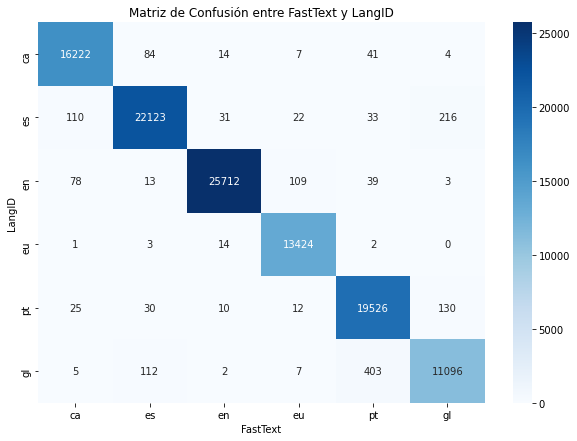

In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(train['lang_detected:langid'], train['lang_detected:fasttext'], labels=['ca', 'es', 'en', 'eu', 'pt', 'gl'])
conf_matrix_df = pd.DataFrame(conf_matrix, index=['ca', 'es', 'en', 'eu', 'pt', 'gl'], columns=['ca', 'es', 'en', 'eu', 'pt', 'gl'])

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('FastText')
plt.ylabel('LangID')
plt.title('Matriz de Confusión entre FastText y LangID')
plt.show()

In [18]:
# We just keep the rows whose language is the same in the 3 classifications
train = train[(train['lang_detected:fasttext'] == train['lang_detected:langid']) & 
              (train['lang_detected:fasttext'] == train['lang_detected:all_fasttext'])]


In [19]:
train.rename(columns={'lang_detected:langid': 'detected_language'}, inplace=True)


<ipython-input-19-3e95a014fb55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'lang_detected:langid': 'detected_language'}, inplace=True)


### Checking

#### Some stats

In [20]:
train['label'].value_counts()
train['detected_language'].value_counts()

detected_language
en    25702
es    22119
pt    19522
ca    16195
eu    13419
gl    11095
Name: count, dtype: int64

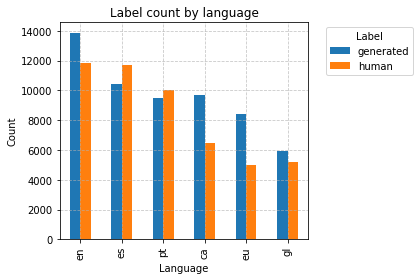

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

train_grouped = train.groupby('detected_language')['label'].value_counts().unstack().fillna(0)
train_grouped = train_grouped.loc[train_grouped.sum(axis=1).sort_values(ascending=False).index]

ax = train_grouped.plot(kind='bar', stacked=False)
plt.xlabel('Language')
plt.ylabel('Count')

plt.title('Label count by language')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7) 
plt.tight_layout()                         # Adding style
plt.show()

In [22]:
train_en = train[train['detected_language'] == 'en']
train_es = train[train['detected_language'] == 'es']
train_pt = train[train['detected_language'] == 'pt']
train_gl = train[train['detected_language'] == 'gl']
train_eu = train[train['detected_language'] == 'eu']
train_ca = train[train['detected_language'] == 'ca']

#### Sampling

In [23]:

# Dictionary to store samples for each language
samples_by_language = {}

# Number of samples per language
samples_per_language = 10

# Iterate over each language and select random samples
for language in train['detected_language'].unique():
    language_samples = train[train['detected_language'] == language].sample(samples_per_language)
    samples_by_language[language] = language_samples

# Concatenate the sampled dataframes
sample_df = pd.concat(samples_by_language.values())

sample_df

,id,text,label,detected_language,lang_detected:all_fasttext,lang_detected:fasttext
27871,140761,"Les aquagliceroporines són un tipus d""aquapori...",human,ca,ca,ca
29124,110627,"Željko ivanek (ljubljana, 15 d""agost de 1957) ...",human,ca,ca,ca
87356,74360,"La parascorpaena picta, coneguda com a peix es...",generated,ca,ca,ca
106054,86170,"Sirvent (cup): ""no entendre com pot ser que no...",generated,ca,ca,ca
44814,32658,Attigada (attagada) fou un antic principat de ...,human,ca,ca,ca
99940,33117,"Nikolaj coster-waldau, popular per interpretar...",human,ca,ca,ca
27020,75700,¡quina aventura! sortir tard del lokal i haver...,generated,ca,ca,ca
105043,34190,"Robert scott hicks, nascut el 4 de març de 195...",human,ca,ca,ca
88741,68169,Rhynchomys banahao és una espècie de rosegador...,generated,ca,ca,ca
65566,70761,El tour de flandes 1919 és la tercera edició d...,human,ca,ca,ca


## Preprocess data

In [24]:
# Galician stop words --> https://github.com/Xangis/extra-stopwords/blob/master/galician
with open('./data/stop words/stopwords_galician.txt', 'r') as file:
    stopwords_galician_1 = [line.strip() for line in file.readlines()]
    stopwords_galician_1 = set(stopwords_galician_1)


In [25]:
# https://github.com/stopwords-iso/stopwords-gl/blob/master/stopwords-gl.txt
with open('data/stop words/stopwords-gl.txt', 'r') as file:
    stopwords_galician_2 = [line.strip() for line in file.readlines()]
    stopwords_galician_2 = set(stopwords_galician_2)

In [26]:
from nltk.corpus import stopwords

sw_en = set(stopwords.words('english'))
sw_es = set(stopwords.words('spanish'))
sw_pt = set(stopwords.words('portuguese'))
sw_ca = set(stopwords.words('catalan'))
sw_eu = set(stopwords.words('basque'))
sw_gl = stopwords_galician_1|stopwords_galician_2

In [27]:
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def text_process(mess, STOPWORDS):
    """
    Takes in a string of text and the stopwords, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a string of the cleaned text
    """
    # Remove punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # Remove stop words
    nostop = ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS and word.isalnum()])
    
    return nostop

# Asegúrate de tener descargadas las stopwords
# import nltk
# nltk.download('stopwords')

def preprocessing(df, STOPWORDS):
    # processing text
    df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))

    # calculate text length
    df['text_len'] = df['clean_text'].apply(len)
    
    # crop unnecessary columns
    df = df.drop(columns=['text', 'detected_language'])

    # map labels
    df['label'] = df['label'].map({'human': 0, 'generated': 1})

    return df


In [28]:
train_en_preprocessed = preprocessing(train_en, sw_en)

<ipython-input-27-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-27-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [29]:
train_es_preprocessed = preprocessing(train_es, sw_es)

<ipython-input-27-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-27-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [30]:
train_pt_preprocessed = preprocessing(train_pt, sw_pt)

<ipython-input-27-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-27-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [31]:
train_ca_preprocessed = preprocessing(train_ca, sw_ca)

<ipython-input-27-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-27-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [32]:
train_eu_preprocessed = preprocessing(train_eu, sw_eu)

<ipython-input-27-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-27-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [33]:
train_gl_preprocessed = preprocessing(train_gl, sw_gl)

<ipython-input-27-6c50afa3afff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(text_process, args=(STOPWORDS,))
<ipython-input-27-6c50afa3afff>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['clean_text'].apply(len)


In [34]:
train_preprocessed = pd.concat([train_gl_preprocessed, train_ca_preprocessed, train_pt_preprocessed, train_eu_preprocessed, train_es_preprocessed, train_en_preprocessed])
train_preprocessed

,id,label,lang_detected:all_fasttext,lang_detected:fasttext,clean_text,text_len
5,91814,1,gl,gl,saída trives baiona será ás 8 30h mañá praza c...,211
17,140701,0,gl,gl,illas columbretes son conxunto catro grupos il...,1361
29,39136,0,gl,gl,bioloxía evolutiva desenvolvemento tamén evolu...,2287
32,95882,0,gl,gl,todos sindicatos presentes reunión rexeitamos ...,1370
34,62806,1,gl,gl,300 novela gráfica é obra arte ficción escrito...,452
...,...,...,...,...,...,...
109643,94952,0,en,en,rtion every little however one dog another wou...,836
109647,1078,0,en,en,mark xvii mark 17 often refers 17th version pr...,781
109654,122155,1,en,en,marianne recovered injury changed woman gone l...,1246
109660,144741,1,en,en,irish president signed longawaiting mother bab...,1548


In [35]:
root = './data/competition_2024/new_preprocessed_data_subtask1/'

# train_en_preprocessed.to_csv(root+'train_en_preprocessed.csv')
# train_es_preprocessed.to_csv(root+'train_es_preprocessed.csv')
# train_ca_preprocessed.to_csv(root+'train_ca_preprocessed.csv')
# train_pt_preprocessed.to_csv(root+'train_pt_preprocessed.csv')
# train_eu_preprocessed.to_csv(root+'train_eu_preprocessed.csv')
# train_gl_preprocessed.to_csv(root+'train_gl_preprocessed.csv')

# train_preprocessed.to_csv(root+'train_preprocessed.csv')


## Exploration

### Plot length

In [ ]:

def plot_length(corpus, lan):
    
    plt.figure(figsize=(12, 8))

    corpus[corpus.label == 0].text_len.plot(bins=35, kind='hist', color='blue', 
                                           label='Human texts', alpha=0.5)
    corpus[corpus.label == 1].text_len.plot(bins=35, kind='hist', color='red', 
                                           label='Generated texts', alpha=0.5)
    plt.xlabel("Message Length")
    plt.title(f'Texts length for {lan} language')
    plt.legend(title='Texts', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.savefig(f'Texts length for {lan} language.png')

    plt.show()
    print(f"{lan} -> Average Human text length: {corpus[corpus.label == 0]['text_len'].mean()}")
    print(f"{lan} -> Average Computer text length: {corpus[corpus.label == 1]['text_len'].mean()}")
    print()
    


In [ ]:
train = [(train_en_preprocessed, 'English'), (train_es_preprocessed, 'Spanish'), (train_pt_preprocessed, 'Portuguese'),
        (train_ca_preprocessed, 'Catalan'), (train_eu_preprocessed, 'Basque'), (train_gl_preprocessed, 'Galician'),
        (train_preprocessed, 'All')]

for train_data, lan in train:
    plot_length(train_data, lan)

### Common words

In [ ]:
def plot_common_words(corpus, type, lan):
    if type=='human':
        words = corpus[corpus.label == 0]['clean_text'].apply(lambda x: x.split())
    elif lan=='Portuguese' and type!='human':
#         w = corpus[corpus.label==1].clean_text.to_list()
#         words = []

#         for line in w:
#             if type(line)!=float and type(line)!=str:
#                 for x in line.split():
#                     words.append(x)
        return
    else:
        words = corpus[corpus.label == 1]['clean_text'].apply(lambda x: x.split())
    

    ham_words= Counter()
    for msg in words:
        ham_words.update(msg)
        
    print(ham_words.most_common(50))
        
    common_words = [word[0] for word in ham_words.most_common(20)]
    word_counts = [word[1] for word in ham_words.most_common(20)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(common_words, word_counts, color='skyblue')
    plt.title(f'Top 20 Most Common Words in {type} {lan} texts Labeled Data')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10

for train_data, lan in train:
    plot_common_words(train_data, 'human', lan)
    plot_common_words(train_data, 'computer', lan)


## Validation

In [ ]:
def train_test(corpus, test):
    x_train, x_test, y_train, y_test = train_test_split(corpus.loc[:'clean_text'],
                                                       corpus['label'], test_size=test, random_state=42)
    print("Dimensions of Training subset")
    print(x_train.shape)
    print(x_test.shape)
    
    print("Dimensions of Testing subset")
    print(y_train.shape)
    print(y_test.shape)
    print()
          
    return x_train['clean_text'], x_test['clean_text'], y_train, y_test

In [ ]:
x_train_en, x_test_en, y_train_en, y_test_en = train_test(train_en_preprocessed, 0.2)
x_train_es, x_test_es, y_train_es, y_test_es = train_test(train_es_preprocessed, 0.2)
x_train_ca, x_test_ca, y_train_ca, y_test_ca = train_test(train_ca_preprocessed, 0.2)
x_train_eu, x_test_eu, y_train_eu, y_test_eu = train_test(train_eu_preprocessed, 0.2)
x_train_gl, x_test_gl, y_train_gl, y_test_gl = train_test(train_gl_preprocessed, 0.2)
x_train_pt, x_test_pt, y_train_pt, y_test_pt = train_test(train_pt_preprocessed, 0.2)


In [ ]:
x_train, x_test, y_train, y_test = train_test(train_preprocessed, 0.2)
x_train

## Minable view

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Bag of Words

vect = CountVectorizer()

# Bag of Words (Term-frequency)
## Represent the text considering the term frequency of words
### considering the frequency of the terms (binary=False), and removing stopwords (stop_words="english")

term_frequency = CountVectorizer(binary=False)


# Bigrams of Words (Term-Frequency)
## Represent the text considering the frequency of pairs of adjacent words.
### considering the frequency of the bigrams of words (binary=False), and removing stopwords (stop_words="english")

two_gram_tf = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=False)


# TF-IDF
tfidf_vectorizer = TfidfVectorizer()

In [ ]:

def text_representations(train_corpus, test_corpus, model):
    # Learn training data vocabulary, then use it to create a document-term matrix
    x_train_tr = model.fit_transform(train_corpus)
    
    # Examine the document-term matrix
    print("Training document-term matrix:")
    print("Shape:", x_train_tr.shape)
    print("Density:", x_train_tr.nnz / (x_train_tr.shape[0] * x_train_tr.shape[1]))
    
    vocab_size = len(model.vocabulary_)
    print("Vocabulary size:", vocab_size)
    
    # Transform testing data (using fitted vocabulary) into a document-term matrix
    x_test_tr = model.transform(test_corpus)
    
    print("\nTesting document-term matrix:")
    print("Shape:", x_test_tr.shape)
    print("Density:", x_test_tr.nnz / (x_test_tr.shape[0] * x_test_tr.shape[1]))
    
    return x_train_tr, x_test_tr


#### Bag of words

In [ ]:
x_train_v_en, x_test_v_en = text_representations(x_train_en, x_test_en, vect)
x_train_v_es, x_test_v_es = text_representations(x_train_es, x_test_es, vect)
x_train_v_ca, x_test_v_ca = text_representations(x_train_ca, x_test_ca, vect)
x_train_v_pt, x_test_v_pt = text_representations(x_train_pt, x_test_pt, vect)
x_train_v_eu, x_test_v_eu = text_representations(x_train_eu, x_test_eu, vect)
x_train_v_gl, x_test_v_gl = text_representations(x_train_gl, x_test_gl, vect)

#### TF-IDF

In [ ]:
x_train_tfidf_en, x_test_tfidf_en = text_representations(x_train_en, x_test_en, tfidf_vectorizer)
x_train_tfidf_es, x_test_tfidf_es = text_representations(x_train_es, x_test_es, tfidf_vectorizer)
x_train_tfidf_ca, x_test_tfidf_ca = text_representations(x_train_ca, x_test_ca, tfidf_vectorizer)
x_train_tfidf_pt, x_test_tfidf_pt = text_representations(x_train_pt, x_test_pt, tfidf_vectorizer)
x_train_tfidf_eu, x_test_tfidf_eu = text_representations(x_train_eu, x_test_eu, tfidf_vectorizer)
x_train_tfidf_gl, x_test_tfidf_gl = text_representations(x_train_gl, x_test_gl, tfidf_vectorizer)

## Models and evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score

logreg = LogisticRegression(solver='liblinear')

In [ ]:
def train_test_model(model, x_train, y_train, x_test, y_test):
    %time model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    y_test_prob = model.predict_proba(x_test)[:1]
    
    # calculate accuracy of class predictions
    print("=======Accuracy Score===========")
    print(metrics.accuracy_score(y_test, y_test_pred))

    # print the confusion matrix
    print("=======Confusion Matrix===========")
    print(metrics.confusion_matrix(y_test, y_test_pred))

    # calculate AUC
    print("=======ROC AUC Score===========")
    print(metrics.roc_auc_score(y_test, y_test_pred))

    print(f"F1-score for Logistic Regression model: {f1_score(y_test, y_test_pred, average='macro')}")
    print()

### Logistic regresion

In [ ]:
train_test_model(logreg, x_train_v_en, y_train_en, x_test_v_en, y_test_en)
train_test_model(logreg, x_train_v_es, y_train_es, x_test_v_es, y_test_es)
train_test_model(logreg, x_train_v_pt, y_train_pt, x_test_v_pt, y_test_pt)
train_test_model(logreg, x_train_v_ca, y_train_ca, x_test_v_ca, y_test_ca)
train_test_model(logreg, x_train_v_eu, y_train_eu, x_test_v_eu, y_test_eu)
train_test_model(logreg, x_train_v_gl, y_train_gl, x_test_v_gl, y_test_gl)